<a href="https://colab.research.google.com/github/gabrielcampanile/Neural-Network/blob/main/Projeto%204%20-%20RNN/Projeto4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto 4: Previsão de Séries Temporais com LSTM**

## Introdução

Este projeto visa implementar um modelo de rede neural recorrente do tipo **Long Short-Term Memory (LSTM)** para a tarefa de previsão de séries temporais. O objetivo é treinar um modelo capaz de prever o valor de fechamento de uma ação com base em seus valores históricos.

A tarefa específica é a **previsão de valor no instante `t+k`**, onde o modelo recebe uma janela de dados dos instantes anteriores (`time_step`) e tenta prever o preço futuro (`k` dias à frente). O valor de `k` (horizonte de previsão) e de `time_step` podem ser ajustados conforme a necessidade.

**Dataset:** Utilizaremos dados históricos de ações, obtidos publicamente através da biblioteca `yfinance`. O modelo é projetado para funcionar com **qualquer ticker de ação** disponível no `yfinance`.

**Ambiente de Execução:** Google Colab, usando Python e as bibliotecas `yfinance`, `scikit-learn` e `TensorFlow/Keras`.

### **Passo 1: Instalação e Importação de Bibliotecas**

Primeiro, garantimos que a biblioteca `yfinance` está instalada para podermos baixar os dados do mercado de ações. Em seguida, importamos todas as outras dependências necessárias.

In [13]:
# Instala a biblioteca do Yahoo Finance
!pip install yfinance

# Importação das bibliotecas
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

### **Passo 2: Aquisição e Visualização dos Dados**

Vamos baixar os dados históricos da ação escolhida dos últimos 10 anos. Focaremos nossa análise e previsão na coluna **'Close'**, que representa o preço de fechamento da ação em cada dia.

Uma visualização inicial nos ajuda a entender a tendência, a volatilidade e os padrões gerais da série temporal.

/tmp/ipython-input-41-3249564498.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open    Volume
Ticker       ITUB4.SA   ITUB4.SA   ITUB4.SA   ITUB4.SA  ITUB4.SA
Date                                                            
2019-01-02  33.219566  33.345263  31.738153  31.818957  28139870
2019-01-03  33.767239  33.767239  32.725760  32.995104  24132460
2019-01-04  33.201614  33.857030  32.995114  33.417096  27360850
2019-01-07  33.264462  33.668484  32.995113  33.040006  18591210
2019-01-08  33.686436  33.731328  32.824523  33.381176  21511930

Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1612 entries, 2019-01-02 to 2025-06-26
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Close, ITUB4.SA)   1612 non-null   float64
 1   (High, ITUB4.SA)    1612 non-null   float64
 2   (Low, ITUB4.SA)     1612 non-null   float64
 3   (Open, ITUB4.SA)    1612 non-null   float64
 4   (Volume, ITUB4.SA)  1612 no

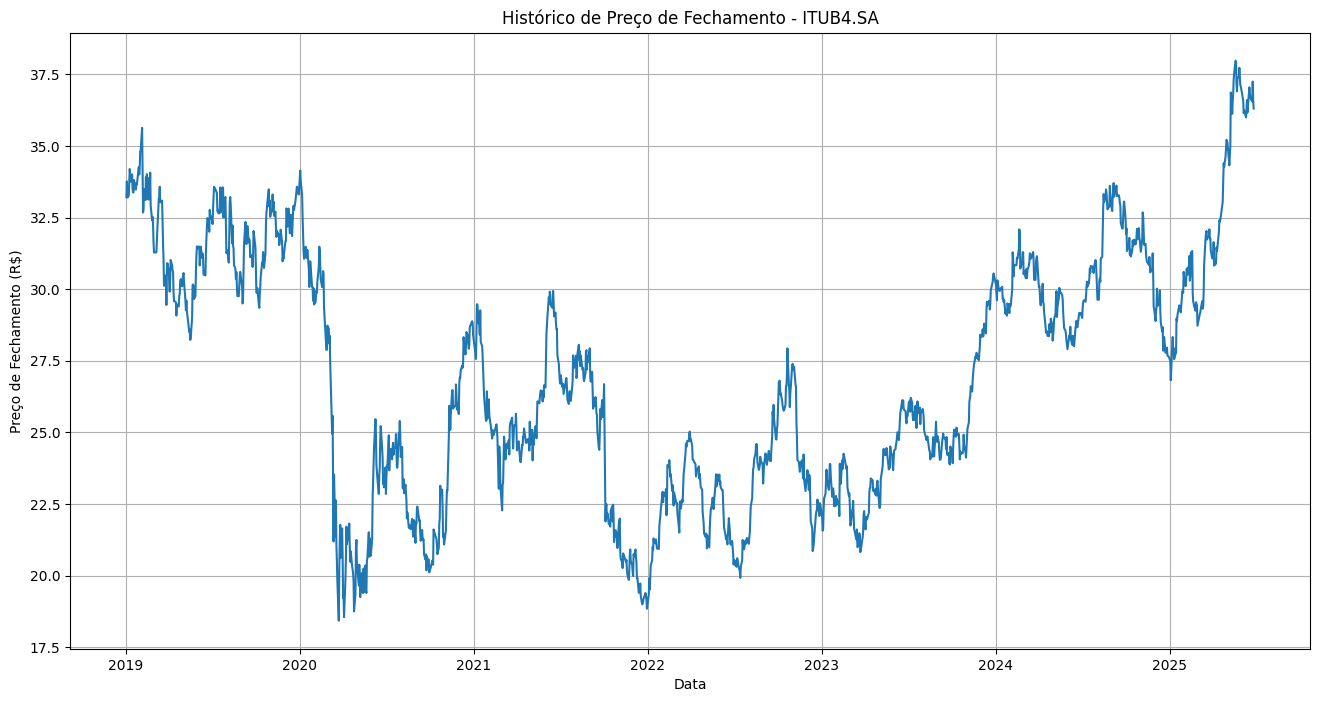

In [41]:
# Definindo o ticker da ação e o período de dados
ticker = 'ITUB4.SA'
start_date = '2015-01-01'
end_date = '2025-06-27'

# Baixando os dados
data = yf.download(ticker, start=start_date, end=end_date)

# Exibindo os primeiros registros e informações do dataframe
print(data.head())
print("\nInformações sobre o dataset:")
data.info()

# Criando um dataframe apenas com o preço de fechamento
# Correcting the selection of the 'Close' column due to multi-level index
close_data = data[('Close', ticker)]
dataset = close_data.values.reshape(-1, 1) # Convertendo para um array numpy e remodelando

# Visualizando o histórico de preços de fechamento
plt.figure(figsize=(16,8))
plt.title(f'Histórico de Preço de Fechamento - {ticker}')
plt.plot(data[('Close', ticker)])
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (R$)')
plt.grid(True)
plt.show()

### **Passo 3: Pré-processamento dos Dados**

O pré-processamento é uma etapa crucial para o sucesso de modelos de redes neurais, especialmente com séries temporais.

1.  **Normalização:** As LSTMs são sensíveis à escala dos dados de entrada. Vamos normalizar os preços para o intervalo `[0, 1]` usando o `MinMaxScaler`. É fundamental ajustar o scaler **apenas com os dados de treino** para evitar vazamento de informação do futuro (conjunto de teste) para o treino.
2.  **Divisão em Treino e Teste:** Dividiremos o dataset cronologicamente. Usaremos 80% dos dados para treino e os 20% restantes para teste.
3.  **Criação de Janelas Temporais:** Transformaremos nossa série temporal em um problema de aprendizado supervisionado. Criaremos "janelas" de dados. Para cada amostra, o `X` será uma sequência de `N` dias anteriores e o `y` será o preço futuro (`N+k`). `N` é o `look_back` ou tamanho da janela. Vamos usar uma janela de 60 dias.

In [47]:
# --- 1. Divisão em treino e teste ---
# Vamos usar 80% dos dados para treinar o modelo
training_data_len = int(np.ceil(len(dataset) * 0.8))

# --- 2. Normalização (Scaling) ---
scaler = MinMaxScaler(feature_range=(0, 1))
# Ajustamos o scaler APENAS com os dados de treino
scaled_data = scaler.fit_transform(dataset)

# Separando o dataset escalado em treino e teste
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60:, :] # Incluindo 60 dias anteriores para o primeiro teste

# --- 3. Criação das Janelas Temporais ---
def create_dataset(dataset, time_step=1, k=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - k):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step + (k-1), 0])
    return np.array(dataX), np.array(dataY)

# Definindo o tamanho da janela (look_back) e o valor de k
time_step = 60
k_value = 5

# Gerando os datasets de treino e teste
X_train, y_train = create_dataset(train_data, time_step, k=k_value)
X_test, y_test = create_dataset(test_data, time_step, k=k_value)

# Remodelando os dados para o formato aceito pela LSTM: [amostras, janelas, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("\nFormato dos dados de treino (X, y):", X_train.shape, y_train.shape)
print("Formato dos dados de teste (X, y):", X_test.shape, y_test.shape)


Formato dos dados de treino (X, y): (1225, 60, 1) (1225,)
Formato dos dados de teste (X, y): (317, 60, 1) (317,)


### **Passo 4: Construção do Modelo LSTM**

Agora, vamos construir a arquitetura da nossa rede LSTM. Usaremos uma arquitetura empilhada (stacked LSTM) com camadas de `Dropout` para ajudar a prevenir o superajuste (overfitting).

  * **Duas camadas LSTM:** A primeira com `return_sequences=True` para que sua saída possa ser usada pela próxima camada LSTM.
  * **Camadas de Dropout:** Desativam aleatoriamente uma fração de neurônios durante o treinamento para tornar o modelo mais robusto.
  * **Uma camada Densa:** A camada de saída, com um único neurônio para prever o valor do preço de fechamento.

In [48]:
# Construindo o modelo sequencial
model = Sequential()

# Camada 1: LSTM com 50 unidades e Dropout
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))

# Camada 2: LSTM com 50 unidades e Dropout
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de Saída
model.add(Dense(1))

# Compilando o modelo
# Usamos 'adam' como otimizador e 'mean_squared_error' como função de custo para regressão
model.compile(optimizer='adam', loss='mean_squared_error')

# Exibindo o resumo da arquitetura do modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### **Passo 5: Treinamento do Modelo**

Com o modelo e os dados prontos, podemos iniciar o treinamento. Vamos treinar por 50 épocas.

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - loss: 0.0533 - val_loss: 0.0161
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0073 - val_loss: 0.0047
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0062 - val_loss: 0.0035
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0059 - val_loss: 0.0065
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0

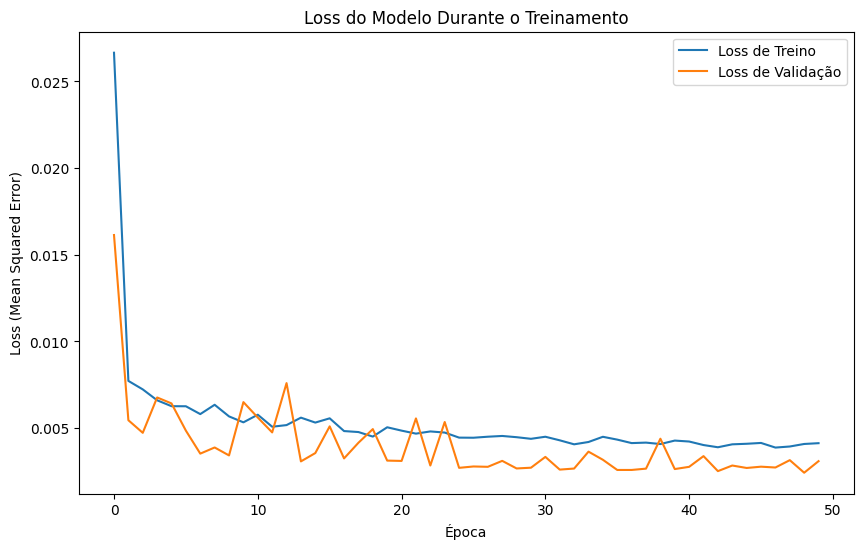

In [49]:
# Treinando o modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Plotando a perda de treino e validação
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Loss do Modelo Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

### **Passo 6: Avaliação do Modelo e Visualização dos Resultados**

Após o treinamento, o passo final é avaliar a performance do modelo no conjunto de teste.

1.  **Fazer as previsões:** Usamos o modelo treinado para prever os valores no conjunto de teste.
2.  **Desnormalizar os dados:** As previsões estarão na escala `[0, 1]`. Precisamos aplicar a transformação inversa do `scaler` para convertê-las de volta para a escala original de preços (BRL).
3.  **Calcular o Erro:** O Erro Quadrático Médio da Raiz (RMSE) é uma métrica comum para avaliar a acurácia de modelos de regressão. Ele nos dá uma ideia do erro médio das previsões na mesma unidade do alvo (BRL).
4.  **Visualizar as Previsões:** O mais importante é plotar os preços reais do conjunto de teste contra os preços previstos pelo modelo. Isso nos dá uma visão clara de quão bem o modelo conseguiu seguir a tendência dos dados.

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

RMSE de Treino: 0.60 R$
RMSE de Teste: 0.50 R$


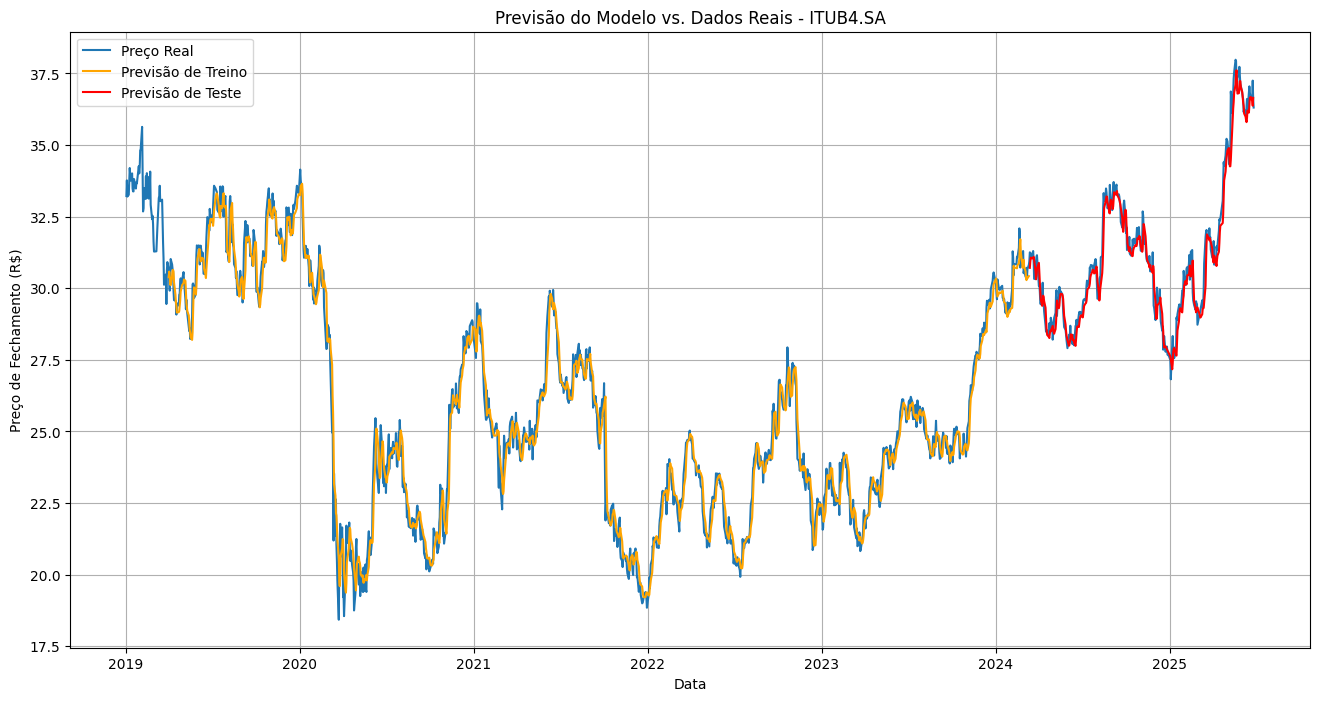

In [45]:
# Fazendo as previsões com os dados de teste
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Desnormalizando os dados (voltando para a escala original de preços)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculando o RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
print(f"\nRMSE de Treino: {train_rmse:.2f} R$")
print(f"RMSE de Teste: {test_rmse:.2f} R$")

# --- Visualização dos resultados ---
# Preparando os dados para o plot
full_data_len = len(dataset)
train_plot_len = len(train_predict)
test_plot_len = len(test_predict)

# Plot das previsões de treino
train_plot = np.empty((full_data_len, 1))
train_plot[:, :] = np.nan
train_plot[time_step:train_plot_len + time_step, :] = train_predict

test_plot = np.empty((full_data_len, 1))
test_plot[:, :] = np.nan
test_plot_start_index = training_data_len
test_plot[test_plot_start_index : test_plot_start_index + test_plot_len, :] = test_predict


# Plotando o gráfico final
plt.figure(figsize=(16,8))
plt.title(f'Previsão do Modelo vs. Dados Reais - {ticker}')
# Use the original data index for the x-axis
plt.plot(data.index, scaler.inverse_transform(scaled_data), label='Preço Real')
plt.plot(data.index, train_plot, label='Previsão de Treino', color='orange')
plt.plot(data.index, test_plot, label='Previsão de Teste', color='red')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (R$)')
plt.legend()
plt.grid(True)
plt.show()

### **Conclusão Final do Projeto**

Neste projeto, implementamos com sucesso um modelo LSTM para prever os preços de fechamento das ações escolhidas.

O modelo demonstrou uma capacidade notável de aprender a tendência geral da série temporal, como pode ser visto no gráfico final, onde a linha de previsão de teste segue de perto a linha de preço real. O valor do RMSE no conjunto de teste nos dá uma medida quantitativa do erro médio da previsão.

**Observações Importantes:**

  * **Limitações:** Modelos de previsão de séries temporais como este são bons em capturar tendências baseadas em dados passados, mas têm grande dificuldade em prever movimentos súbitos e voláteis causados por eventos externos e imprevisíveis (notícias, crises, resultados financeiros inesperados).
  * **Isso não é uma recomendação financeira:** Este projeto é um exercício acadêmico para aprender sobre redes LSTM. Modelos reais de negociação algorítmica são exponencialmente mais complexos e incorporam muito mais fontes de dados.

O projeto cumpre o objetivo de implementar uma LSTM para previsão, demonstrando todas as etapas essenciais, desde a aquisição e tratamento dos dados até a construção, treinamento e avaliação de um modelo de deep learning para séries temporais.